In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore')
!python3 --version

Python 3.6.9 :: Anaconda, Inc.


In [2]:
%%writefile conda_dependencies.yml
dependencies:
    - python=3.6.9
    - numpy=1.18.*
    - pandas=1.1.5
    - pip:
        - azureml-defaults==1.37.0
        - confuse==1.6.0
        - orbit-ml==1.1.0

Overwriting conda_dependencies.yml


In [3]:
%%writefile requirements.txt
confuse==1.6.0
azureml-defaults==1.37.0
confuse==1.6.0
orbit-ml==1.1.0

Overwriting requirements.txt


In [4]:
!pip3 install -r requirements.txt

#### **Damped Local Trend (DLT)**

* global and local trend terms

In [5]:
import pandas as pd
import numpy as np
import orbit
from IPython.display import display

In [6]:
display(orbit.__version__)

'1.1.0'

In [7]:
from orbit.utils.dataset import load_iclaims

us_unemp_claims_df = load_iclaims(transform=True).sort_values(by=['week'],ascending=True)
display(us_unemp_claims_df.head())

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


##### Train Test Split

* Use last year (52 weeks) of data as *Test*, before that as *Train*

In [8]:
import toml, os

parent_dir = os.path.dirname(os.getcwd())
config = toml.load(os.path.join(parent_dir,'config.toml'))
TIME_COL = config['dlt_uber_provided_example']['utils']['TIME_COL']
RESPONSE_COL = config['dlt_uber_provided_example']['utils']['RESPONSE_COL']
test_ind = config['dlt_uber_provided_example']['utils']['test_ind']
train_df, test_df = us_unemp_claims_df[:-test_ind], us_unemp_claims_df[-test_ind:]

#### Three Wrappers for DLT Models

1. ```DLTMAP``` - DLT model for MAP (Maximum a Posteriori)
2. ```DLTFull``` - DLT model for full prediction
    * the prediction occurs as a function of each parameter posterior sample
    * the prediction results are aggregated after prediction
    * prediction will always return the median (aka 50th percentile) along with any additional percentiles that are specified
3. ```DLTAggregated``` - DLT model for aggregated posterior prediction
    * the parameter posterior samples are reduced using aggregate_method ```'mean', 'median'``` before performing a single prediction

In [9]:
from orbit.models import DLT

MAP_KEY = 'dlt_map'
dlt_map = DLT(
    response_col=RESPONSE_COL,
    date_col=TIME_COL,
    estimator=config['dlt_uber_provided_example'][MAP_KEY]['estimator'],
    seasonality=config['dlt_uber_provided_example'][MAP_KEY]['seasonality'],
    seed=config['dlt_uber_provided_example']['utils']['seed']
)

In [10]:
dlt_map.fit(df=train_df)

In [11]:
pred_df = dlt_map.predict(df=test_df, decompose=True)
display(pred_df.head())

,week,prediction,trend,seasonality,regression
0,2017-07-02,12.425738,12.362385,0.063352,0.0
1,2017-07-09,12.545887,12.360202,0.185685,0.0
2,2017-07-16,12.382557,12.358019,0.024538,0.0
3,2017-07-23,12.236135,12.355835,-0.119700,0.0
4,2017-07-30,12.189621,12.353652,-0.164031,0.0


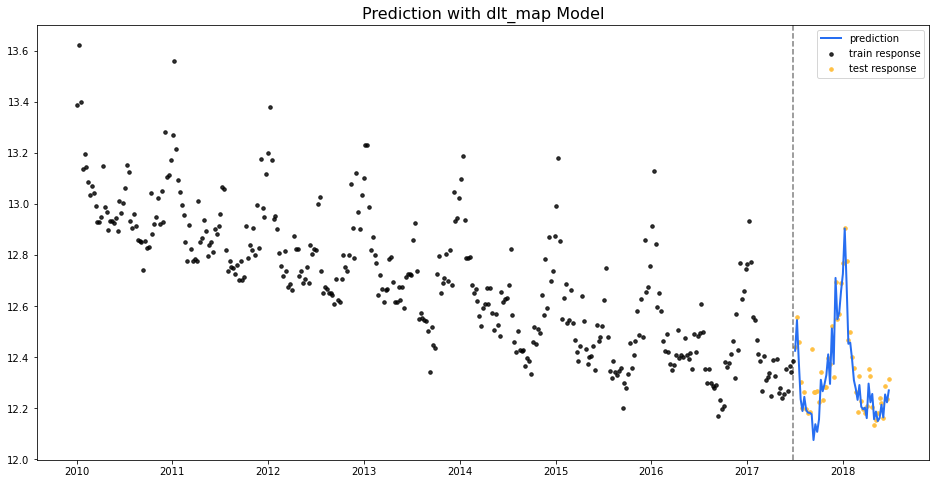

In [12]:
from orbit.diagnostics.plot import plot_predicted_data
import matplotlib.pyplot as plt

# plt.style.available
### open issue on orbit around the plt.style https://github.com/uber/orbit/issues/690
plot_predicted_data(
    training_actual_df=train_df,
    predicted_df=pred_df,
    date_col=TIME_COL,
    actual_col=RESPONSE_COL,
    test_actual_df=test_df,
    title=f"Prediction with {MAP_KEY} Model",
    use_orbit_style=False);